In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf


from IPython import display
%matplotlib inline


from sklearn.metrics import log_loss, accuracy_score, f1_score, classification_report, roc_auc_score, auc

from sklearn.model_selection import KFold, train_test_split

from tqdm import tqdm_notebook

## Investigation

In [2]:
data = pd.read_csv("../data/train.csv")
data.y.value_counts()

1.0    790
0.0    315
Name: y, dtype: int64

Значит имеем задачу классификации, классы не сбалансированы. <br/>
В качестве метрики подойдет roc_auc или f1_score, они чувствительны к ошибкам в обоих классах, будем использовать f1_score. 
  
Хотим сравнить модели отбора признаков, кандидаты следующие, глобально это либо линейные модели с улучшениями для отбора признаков, либо деревья:
- линейные модели с elastic net или lasso прибавками к ошибке
- DFS (сетка из статьи)

- Случайный лес
- AdaBoost (на деревьях)
- Градиентный бустинг (тоже на деревьях)
- LightGBM

Зафиксируем сначала просто трейн\тест разбиение, сохранив баланс классов, потом можно будет погонять кросс-валидацию на 3-5 фолдов.

In [3]:
np.random.seed(239)

In [4]:
X = data[data.columns[:-1]].values
y = data.y.values

In [5]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y)

In [6]:
## Check ballance
print("train: ", y_tr.sum()/y_tr.shape[0])
print("test: ", y_te.sum()/y_te.shape[0])
print("all: " , y.sum()/y.shape[0])

train:  0.714975845410628
test:  0.7148014440433214
all:  0.7149321266968326


Общий подход будет следующий:
- Учим несколько моделей с разными параметрами на трейн сете
- Вытаскиваем feature importances
- Смотрим насколько параметры модели влияют на ранжирование фичей
- Учим модели с разным количеством фичей, добавляя жадно от самой важной (это не обязательно лучшая стратегия, но быстрая)
- Выбираем лучший набор фичей с точки зрения f1_score
- Возможно подтюниваем параметры модели


- Пробуем кросс валидацию на несколько фолдов

## Tree based models

#### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
rf = RandomForestClassifier(100)
rf.fit(X_tr, y_tr)
rf_pred = rf.predict_proba(X_te)

In [53]:
print(roc_auc_score(y_te, rf_pred[:,1]))
print(classification_report(y_te, rf_pred[:,1] > 0.5))

0.9447001662191535
             precision    recall  f1-score   support

        0.0       0.86      0.68      0.76        79
        1.0       0.88      0.95      0.92       198

avg / total       0.88      0.88      0.87       277



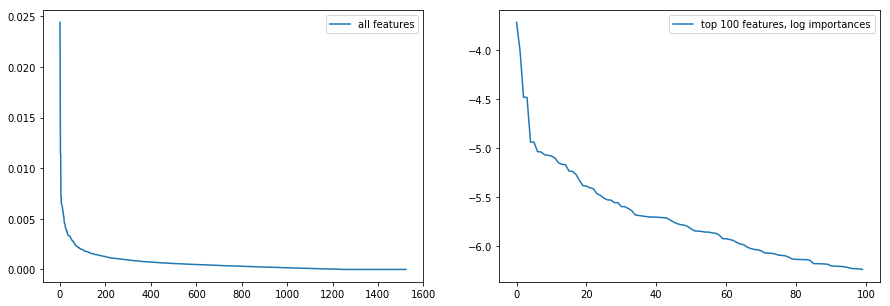

In [54]:
f, (a1, a2) = plt.subplots(1,2,figsize=(15,5))
a1.plot(sorted(rf.feature_importances_)[::-1][:], label = 'all features')
a2.plot(np.log(sorted(rf.feature_importances_)[::-1][:100]), label = 'top 100 features, log importances')
a1.legend()
a2.legend()
plt.show()

Какого-то явного скачка не видно в графиках важности фичей.

In [39]:
def verify_model(model, X_tr, y_tr, X_te, y_te, feature_importances, metric, feature_range, step):
    sorted_importances_args_r = np.argsort(feature_importances)[::-1]
    
    scores = np.zeros((2, (feature_range[1] - feature_range[0]) // step))
    for i, top_features in tqdm_notebook(enumerate(range(feature_range[0], feature_range[1], step))):
        mask = np.zeros(X.shape[1]).astype(bool)
        mask[sorted_importances_args_r[:top_features]] = True
        
        model.fit(X_tr[:,mask], y_tr)
        pred_proba = model.predict_proba(X_te[:,mask])[:,1]
        
        scores[0, i] = top_features
        scores[1, i] = metric(y_te, pred_proba)
        #print(top_features, metric(y_te, pred_proba))
        #print(classification_report(y_te, rf_pred[:,1] > 0.5))
    return scores

In [55]:
rf_test = RandomForestClassifier(100)
rf_scores = verify_model(rf_test, X_tr, y_tr, X_te, y_te, rf.feature_importances_, roc_auc_score, [1,60], 1)

A Jupyter Widget

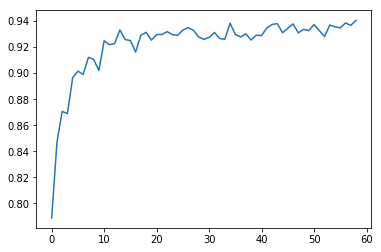

In [56]:
plt.plot(rf_scores[1])

На глаз логичный порог в районе 15 фичей, хотя результат с 60-ю лучше. Для деревьев это нормально, даже незначительные фичи, могут дать небольшой прирост качества

In [57]:
np.save("../storage/rf_feature_importances", rf.feature_importances_)

#### Gradient Boosting

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

Преред тем как что-то делать, стандартизируем данные, чтобы среднее было 0, а величина в диапазоне от -1 до 1. (для RF это было не важно)

In [233]:
def standartize(X):
    div = np.abs((X - X.mean(0))).max(0)
    div[div == 0] = 1
    return (X - X.mean(0)) / div

In [234]:
X_tr_s, X_te_s = standartize(X_tr), standartize(X_te)

In [553]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, verbose=1)
gb.fit(X_tr_s, y_tr)
gb_pred = gb.predict_proba(X_te_s)

      Iter       Train Loss   Remaining Time 
         1           1.0779           12.62s
         2           0.9887           13.32s
         3           0.9160           12.87s
         4           0.8558           12.93s
         5           0.8063           12.63s
         6           0.7614           12.43s
         7           0.7225           12.27s
         8           0.6885           12.17s
         9           0.6541           12.12s
        10           0.6258           12.03s
        20           0.4434           10.62s
        30           0.3468            9.14s
        40           0.2942            7.70s
        50           0.2621            6.34s
        60           0.2392            5.04s
        70           0.2131            3.76s
        80           0.1932            2.50s
        90           0.1774            1.25s
       100           0.1613            0.00s


In [554]:
print(roc_auc_score(y_te, gb_pred[:,1]))
print(classification_report(y_te, gb_pred[:,1] > 0.5))

0.914588927247155
             precision    recall  f1-score   support

        0.0       0.73      0.80      0.76        79
        1.0       0.92      0.88      0.90       198

avg / total       0.86      0.86      0.86       277



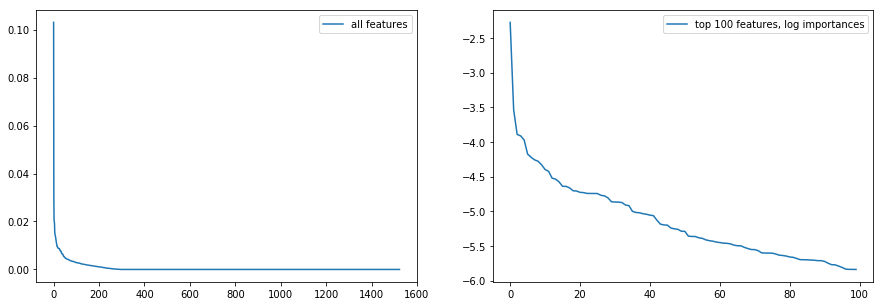

In [555]:
f, (a1, a2) = plt.subplots(1,2,figsize=(15,5))
a1.plot(sorted(gb.feature_importances_)[::-1][:], label = 'all features')
a2.plot(np.log(sorted(gb.feature_importances_)[::-1][:100]), label = 'top 100 features, log importances')
a1.legend()
a2.legend()
plt.show()

In [559]:
gb_test = GradientBoostingClassifier()
gb_scores = verify_model(gb_test, X_tr_s, y_tr, X_te_s, y_te, gb.feature_importances_, roc_auc_score, [1,100], 1)

A Jupyter Widget

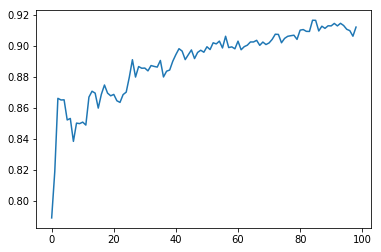

In [561]:
plt.plot(gb_scores[1])

Сравним на глаз фичи отобранные RF и GB (тут хорошо бы какую-нибудь ранжирующую метрику DCG(?) нет времени разбираться)

In [563]:
np.argsort(rf.feature_importances_)[::-1][:50]

array([1460,  458,  545,  868,  132,  557, 1386,   63,    8,   21, 1212,
        226,  101,   96, 1213,   91, 1025,  569,  884,  814,  224,  887,
        920,  362,  108,   62,    6, 1305,  862,  563,  697,  228,  354,
        503,   98, 1077,    9,  461,  134,  103,  464,   87,  973,   16,
       1395,  526,  364,  331,  355,  837])

In [564]:
np.argsort(gb.feature_importances_)[::-1][:50]

array([1460, 1077,  214, 1004, 1045,   35,  854,  562,  403,  800,  701,
        574,  128, 1286,  834,  545,  881,  126,  717,  873,  429, 1303,
        382, 1025,  862,  857,  370, 1302,  869,  687,  226,  595,  605,
        600,  719,  839,   20,  805,  796, 1089,   63,  621,  781,  364,
         26,  195,  437, 1018,  725,  929])

Посмотрим пересечение в топ 100

In [567]:
len(set(np.argsort(rf.feature_importances_)[::-1][:100]).intersection(set(np.argsort(gb.feature_importances_)[::-1][:100])))

19

Всего 19 общих! Фичи выбранные random forest и gradient boosting очень отличаются. Наверное бустинг можно потюнить (уменьшить глубину деервьев, покрутить learning rate). Пока оставим это так.

## Linear Models

В отличие от статьи, у нас классификация бинарная, значит нет причин не использовать стандартные модели с l1 регуляризацией.

С линейными моделями все немного не так как с деревьями, l1 регуляризации дадут нам разряженый вектор весов, так что у нас не будет возможности сортировать по feature importance. Количество фичей будет отбираться за счет веса регуляризации.



В данных наверняка есть скореллированные столбцы, для лассо это не должно быть критично
https://arxiv.org/pdf/1204.1605.pdf


In [232]:
class_weights = {0.: (y_tr == 0).sum() / y_tr.shape[0], 1.: (y_tr == 1).sum() / y_tr.shape[0]}

#### Lasso

In [71]:
from sklearn.linear_model import LogisticRegression

Попробуем поискать параметр регуляризации

In [122]:
def check_lasso(C, X_tr, y_tr, X_te, y_te, c_w):
    lr_lasso = LogisticRegression('l1', C = C, class_weight=c_w)
    lr_lasso.fit(X_tr, y_tr)
    lasso_pred = lr_lasso.predict_proba(X_te)
    return roc_auc_score(y_te, lasso_pred[:,1]), (lr_lasso.coef_ != 0).sum(), lr_lasso

In [240]:
good_C_logspace = np.logspace(-2, 1, n, base=10)
print(good_C_logspace)

[ 0.01        0.02154435  0.04641589  0.1         0.21544347  0.46415888
  1.          2.15443469  4.64158883 10.        ]


In [241]:
n = 10
lasso_scores_vs_nonzeros = np.zeros((3,n))
lasso_models = []

for i, C in tqdm_notebook(enumerate(good_C_logspace)):
    res = check_lasso(C, X_tr_s, y_tr, X_te_s, y_te, class_weights)
    lasso_scores_vs_nonzeros[1:, i] = res[:-1]
    lasso_scores_vs_nonzeros[0, i] = C
    
    lasso_models.append(res[-1])

A Jupyter Widget

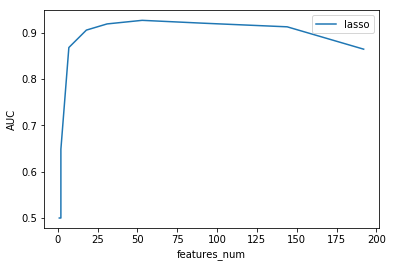

In [242]:
plt.plot(lasso_scores_vs_nonzeros[2], lasso_scores_vs_nonzeros[1], label = 'lasso')
plt.xlabel("features_num")
plt.ylabel("AUC")
plt.legend()

Lasso рекоммендует что-то в районе 20 - 50 фичей, посмотрим какой регуляризации это соответсвует, и поищем в том регионе еще полуше (да, придется копировать код, потому что я спешу)

In [248]:
lasso_scores_vs_nonzeros

array([[1.00000000e-02, 2.15443469e-02, 4.64158883e-02, 1.00000000e-01,
        2.15443469e-01, 4.64158883e-01, 1.00000000e+00, 2.15443469e+00,
        4.64158883e+00, 1.00000000e+01],
       [5.00000000e-01, 5.00000000e-01, 6.48478455e-01, 8.68431147e-01,
        9.06086178e-01, 9.19447641e-01, 9.27183225e-01, 9.21045902e-01,
        9.13182457e-01, 8.64851042e-01],
       [1.00000000e+00, 2.00000000e+00, 2.00000000e+00, 7.00000000e+00,
        1.80000000e+01, 3.10000000e+01, 5.30000000e+01, 9.10000000e+01,
        1.44000000e+02, 1.92000000e+02]])

In [254]:
good_C_logspace_2 = np.logspace(-1, 0.5, n, base=10)
print(good_C_logspace_2)

[0.1        0.14677993 0.21544347 0.31622777 0.46415888 0.68129207
 1.         1.46779927 2.15443469 3.16227766]


In [255]:
n = 10
lasso_scores_vs_nonzeros_2 = np.zeros((3,n))
lasso_models_2 = []

for i, C in tqdm_notebook(enumerate(good_C_logspace_2)):
    res = check_lasso(C, X_tr_s, y_tr, X_te_s, y_te, class_weights)
    lasso_scores_vs_nonzeros_2[1:, i] = res[:-1]
    lasso_scores_vs_nonzeros_2[0, i] = C
    
    lasso_models_2.append(res[-1])

A Jupyter Widget

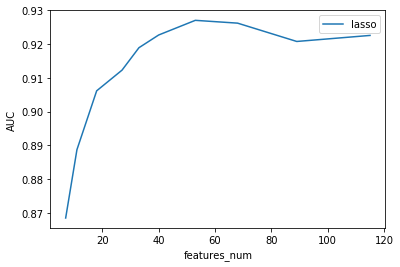

In [256]:
plt.plot(lasso_scores_vs_nonzeros_2[2], lasso_scores_vs_nonzeros_2[1], label = 'lasso')
plt.xlabel("features_num")
plt.ylabel("AUC")
plt.legend()

Прямо хорошо модели становится, когда мы сохраняем около 55 фичей, посмотрим что за фичи и сколько их

In [258]:
model_num = lasso_scores_vs_nonzeros_2[1].argmax()

In [261]:
lasso_best_model = lasso_models_2[model_num]
np.save("../storage/lasso_feature_importance", lasso_best_model.coef_[0])

In [572]:
print('Selected : ', np.sort(np.where(lasso_best_model.coef_[0] != 0)[0])) 

Selected :  [  47   79   83   87  367  376  381  456  457  458  463  472  478  491
  542  545  557  569  575  609  649  662  666  672  702  789  795  799
  803  805  806  807  879  881  982  990 1013 1025 1053 1082 1088 1191
 1214 1296 1332 1350 1387 1394 1395 1424 1426 1460 1523]


In [571]:
np.sort(np.argsort(rf.feature_importances_)[::-1][:50])

array([   6,    8,    9,   16,   21,   62,   63,   87,   91,   96,   98,
        101,  103,  108,  132,  134,  224,  226,  228,  331,  354,  355,
        362,  364,  458,  461,  464,  503,  526,  545,  557,  563,  569,
        697,  814,  837,  862,  868,  884,  887,  920,  973, 1025, 1077,
       1212, 1213, 1305, 1386, 1395, 1460])

Снова разные фичи! 

## Elastic Net && DFS

Обе модели подразумевают какой-нибуь вид SGD для решения, используют похожую регурялизацю, так что можно сделать две похожих tf модельки для DFS и Elastic Net. 

Работать будем с Elastic Net лог регрессией и с DFS сразу многослойной.

In [265]:
from keras.layers import Dense

Using TensorFlow backend.


In [273]:
class WeightLayer:
    '''Weight layer, simply performs elementwise multiplication between input and weights'''
    def __init__(self, shape, name, w=None):
        self.shape = shape
        self.name = name
        
        with tf.variable_scope(name) as scope:
            if w is None:
                self.w = tf.get_variable('w', shape=shape, initializer=None, trainable=True)
            else:
                self.w = w
        self.scope = scope
        
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                out = self.w * inp
                return out                

In [305]:
class ElasticNet:
    '''
    Class for ElasticNet model.
    Also responsible for creating loss terms
    '''
    def __init__(self, name, input_shape):
        self.name = name
        self.input_shape = input_shape
        
        with tf.variable_scope(name) as scope:
            self.dense = Dense(1, activation=None)
        self.scope = scope
    
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):                
                logits = self.dense(inp)
                out = tf.nn.sigmoid(logits)
        return logits, out
        
    def get_regularization_term(self, alpha):
        with tf.variable_scope("regularization"):
            return  (1-alpha) * tf.reduce_sum(tf.abs(self.dense.weights[0])) +\
                        alpha * tf.reduce_sum(tf.square(self.dense.weights[0]))


In [306]:
class DFS:
    '''
    Class for DFS model.
    Also responsible for creating loss terms
    '''
    def __init__(self, name, input_shape, dense_sizes=[256, 256]):
        self.name = name
        self.input_shape = input_shape
        
        with tf.variable_scope(name) as scope:
            self.weight_layer = WeightLayer(input_shape, 'wl')
            self.dense_array = [Dense(x, activation=tf.nn.relu) for x in dense_sizes] + [Dense(2, activation=None)]
        self.scope = scope
    
    def __call__(self, inp):
        with tf.variable_scope(self.scope):
            with tf.name_scope(self.scope.original_name_scope):
                weight_layer_out = self.weight_layer(inp)
                next_var = weight_layer_out
                for layer in self.dense_array:
                    next_var = layer(next_var)
                
                logits = next_var
                out = tf.nn.softmax(logits)
        return logits, out

    def get_weighted_layer_regularization_term(self, alpha):
        with tf.variable_scope("weighted_layer_regularization"):
            return (1-alpha) * tf.reduce_sum(tf.abs(self.weight_layer.w)) +\
                    alpha * tf.reduce_sum(tf.square(self.weight_layer.w))
        
    def get_dense_layers_regularization_term(self, alpha):
        with tf.variable_scope("dense_layers_regularization"):
            r_term = 0
            for layer in self.dense_array:
                r_term += (1-alpha) * tf.reduce_sum(tf.abs(layer.weights[0])) +\
                            alpha * tf.reduce_sum(tf.square(layer.weights[0]))

            return r_term

In [413]:
class experiment:
    '''Performs experiment with either ElasticNet or DFS, stores parametres of the experiment'''
    def __init__(self,
                 name,
                 feature_mask,
                 session,
                 model_type='dfs',
                 lambda_1=0.001,
                 lambda_2=0.5,
                 alpha_1=0.00002,
                 alpha_2=0.5,
                 dense_sizes = [256, 256]):
        self.name = name
        self.session = session
        self.feature_mask = feature_mask
        self.n_features = self.feature_mask.sum()
        if not model_type in ['elastic', 'dfs']:
            raise ValueError("model can be either 'dfs' or 'elastic'")
        self.model_type = model_type
        
        self.alpha_1 = alpha_1
        self.alpha_2 = alpha_2
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
        self.dense_sizes = dense_sizes
        
        self.ready = False
        
    def _initialize_network(self):
        with tf.variable_scope(self.name) as net_scope:
            ## Initialize network
            self.inp = tf.placeholder(tf.float32, [None, self.n_features])
            if self.model_type == 'dfs':
                self.model = DFS("DFS", self.n_features, self.dense_sizes)
            elif self.model_type == 'elastic':
                self.model = ElasticNet("ElasticNet", self.n_features)                
     
            self.logits, self.out = self.model(self.inp)

            ##Prepare target and loss weights
            self.target = tf.placeholder(tf.float32, [None])
            self.loss_weights = tf.placeholder(tf.float32, [None])

            
            if self.model_type == 'dfs':
                ##Loss terms
                self.ce_loss = tf.losses.softmax_cross_entropy(tf.one_hot(tf.cast(self.target, tf.int32), 2),
                                                               self.logits,
                                                               weights=self.loss_weights)
                self.features_weights_regularization = \
                    self.lambda_1 * self.model.get_weighted_layer_regularization_term(self.lambda_2) 
                self.network_weights_regularization = \
                    self.alpha_1 * self.model.get_dense_layers_regularization_term(self.alpha_2)

                self.loss = self.ce_loss + self.features_weights_regularization + self.network_weights_regularization
            elif self.model_type == 'elastic':
                self.ce_loss = tf.losses.log_loss(self.target, tf.reshape(self.out, [-1]), self.loss_weights)
                
                self.weights_regularization = \
                    self.lambda_1 * self.model.get_regularization_term(self.lambda_2)

                self.loss = self.ce_loss + self.weights_regularization

            ## Optimizer, Adam optimizes everything
            self.optimizer = tf.train.AdamOptimizer()
            self.train_step = self.optimizer.minimize(self.loss, var_list=tf.trainable_variables(self.name))

        ## Initialize only this experiment    
        self.uninitialized_vars = []
        for var in tf.all_variables():
            try:
                sess.run(var)
            except tf.errors.FailedPreconditionError:
                self.uninitialized_vars.append(var)

        init_new_vars_op = tf.initialize_variables(self.uninitialized_vars)
        sess.run(init_new_vars_op)
        
        self.net_scope = net_scope
            
    def _plot_graphs(self, plot_start):
        f, (a1, a2) = plt.subplots(2,1,figsize = (10,10))
        display.clear_output(wait=True)
        a1.plot(self.train_ce_losses[plot_start:], label='train ce')
        a1.plot(self.val_ce_losses[plot_start:], label = 'val ce')

        a2.plot(self.val_auc_scores[:], label='val_auc')

        a1.legend()
        a2.legend()
        plt.show()
             
        
    def run_experiment(self, X_tr, y_tr, X_te, y_te, max_epochs, b_s=40, plot=True, warm_up=40, early_stop=20, plot_start=0):
        if not self.ready:
            self._initialize_network()
            self.ready = True

            self.class_weights = {0.: (y_tr == 0).sum() / y_tr.shape[0], 1.: (y_tr == 1).sum() / y_tr.shape[0]}
            self.val_weights = np.array([self.class_weights[y] for y in y_te])

            self.train_ce_losses = []
            self.val_ce_losses = []
            self.val_auc_scores = []

        for epoch in range(max_epochs):
            train_ce_loss = 0

            for i, (batch_X, batch_y) in enumerate(iterate_minibatches(X_tr, y_tr, b_s)):
                batch_weights = np.array([self.class_weights[y] for y in batch_y])

                batch_loss = self.session.run([self.train_step, self.ce_loss],
                                      feed_dict={self.inp : batch_X[:,self.feature_mask],
                                                 self.target: batch_y,
                                                 self.loss_weights:batch_weights})

                train_ce_loss += batch_loss[1] * batch_X.shape[0]


            val_ce_loss = self.session.run(self.ce_loss,  feed_dict={self.inp : X_te[:,self.feature_mask],
                                                             self.target: y_te,
                                                             self.loss_weights : self.val_weights})
            
            val_pred = self.session.run(self.out, feed_dict={self.inp : X_te[:,self.feature_mask]})
            if self.model_type == 'dfs': val_pred = val_pred[:, 1]
            val_auc_score = roc_auc_score(y_te, val_pred) 

            self.val_ce_losses.append(val_ce_loss)
            self.val_auc_scores.append(val_auc_score)
            self.train_ce_losses.append(train_ce_loss / X_tr.shape[0])


            if plot:
                self._plot_graphs(plot_start)


            if epoch > warm_up:
                if np.argmax(np.array(self.val_auc_scores[-early_stop:])) == 0:
                    print("early stop")
                    break

def iterate_minibatches(x, y, batchsize, shuffle=True):
    if shuffle:
        indices = np.arange(y.shape[0])
        np.random.shuffle(indices)
    for start_idx in range(0, y.shape[0] - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield x[excerpt], y[excerpt]

#### DFS 


Остановка обучения либо по макс кол-ву эпох, либо если за 20 эпох не смогли улучшить val_auc. Еще хорошо бы сохранять веса с лучшей эпохи, но для начала будем считать, что модель не успевает испортиться (графики обучения вполне неплохо свидетельствуют об этом)

Сначала просто попробуем разок обучить и вытащить важность фичей

In [573]:
tf.reset_default_graph()
sess = tf.Session()

In [415]:
exp_1 = experiment("DFS_visual", np.ones(X.shape[1]).astype(bool), sess)

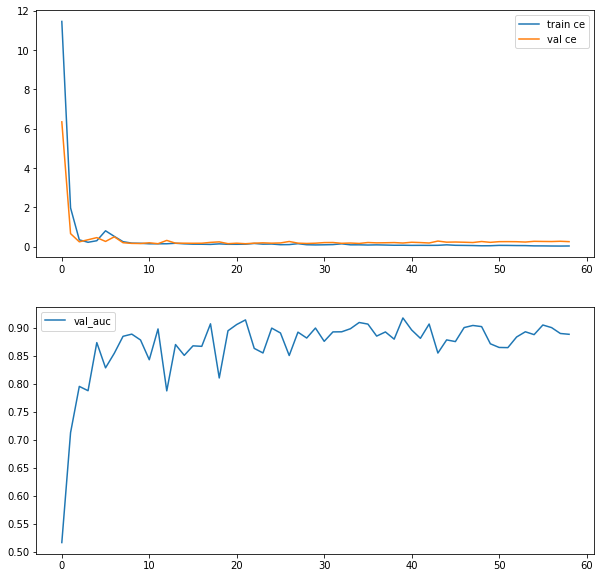

early stop


In [416]:
exp_1.run_experiment(X_tr, y_tr, X_te, y_te, 200)

In [427]:
print("best score :", max(exp_1.val_auc_scores))

best score : 0.9174018667689554


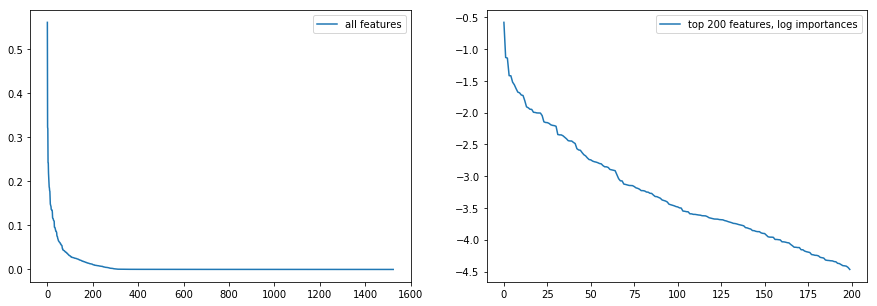

In [422]:
f, (a1, a2) = plt.subplots(1,2,figsize=(15,5))
a1.plot(sorted(np.abs(sess.run(exp_1.model.weight_layer.w)))[::-1][:], label = 'all features')
a2.plot(np.log(sorted(np.abs(sess.run(exp_1.model.weight_layer.w)))[::-1][:200]), label = 'top 200 features, log importances')
a1.legend()
a2.legend()
plt.show()

Я  хотел попробовать подбирать веса, а потом понял, что модель сама по себе очень нестабильна в смысле именно отбора признаков, по-этому можно запустить ее несколько раз и посмотреть какие она даст результаты.

In [517]:
n_exps = 8
multiple_run_results = np.zeros(n_exps)
exps = []


for i in range(n_exps):
    exp = experiment("DFS_" + str(i) ,
                     np.ones(X.shape[1]).astype(bool),
                     sess)
    exp.run_experiment(X_tr, y_tr, X_te, y_te, 200, plot = False)

    multiple_run_results[i] = max(exp.val_auc_scores)
    print("exp_results :", max(exp.val_auc_scores))

    exps.append(exp)


early stop
exp_results : 0.9125431530494822
early stop
exp_results : 0.9154200230149597
early stop
exp_results : 0.9215573456079785
early stop
exp_results : 0.9128628052678686
early stop
exp_results : 0.9101777266334229
early stop
exp_results : 0.9278864595320291
early stop
exp_results : 0.9165068405574734
early stop
exp_results : 0.9045518475898223


Если посмотреть сколько фичей пересекается в топ 100 для таких отдельных запусков, можно увидеть что их очень мало. Это нестабильность, которая идет сквозь все эксперименты. Отранжируем фичи по всем 8-ти экспериментам. Рангом фичи будет такая сумма: $ \sum_{for\ k\ in\ all\ experiments} {{1} \over {(pos_k + 1)} }$

In [518]:
DFS_selected_features = {}

In [519]:
for exp in exps:
    exp_best_features = np.argsort(sess.run(exp.model.weight_layer.w))[::-1][:300]
    for i, feature in enumerate(exp_best_features):
        if feature in DFS_selected_features.keys():
            DFS_selected_features[feature] += 1 / (i + 1)
        else:
            DFS_selected_features[feature] = 1 / (i + 1)

In [520]:
DFS_features_array = np.zeros((2, len(DFS_selected_features)))
for i, (k, v) in enumerate(DFS_selected_features.items()):
    DFS_features_array[0, i] = k
    DFS_features_array[1, i] = v

Построим результаты для стабильно ранжированных фичей, и вытащим наконец в отдельную функцию постройку графиков

In [583]:
def plot_rank(*ranks):
    f, (a1, a2) = plt.subplots(1,2,figsize=(15,5))
    for rank in ranks:
        a1.plot(sorted(np.abs(rank))[::-1][:], label = 'all features')
        a2.plot(np.log(sorted(np.abs(rank)))[::-1][:200], label = 'top 200 features, log importances')
    a1.legend()
    a2.legend()
    plt.show()

In [591]:
def plot_ordered_as_first(*ranks):
    f, (a1, a2) = plt.subplots(1,2,figsize=(15,5))

    order = np.argsort(np.abs(ranks[0]))[::-1]
    for rank in ranks:

        a1.plot(np.abs(rank)[order], label = 'all features')
        a2.plot(np.log(np.abs(rank)[order][:200]), label = 'top 200 features, log importances')
    a1.legend()
    a2.legend()
    plt.show()

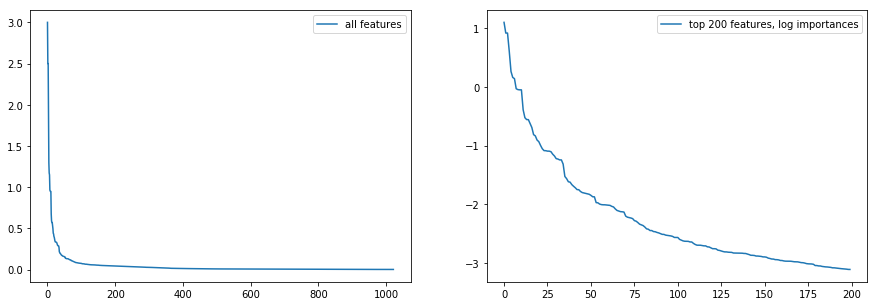

In [522]:
plot_rank(DFS_features_array[1])

Тут нужно пробовать уже строить модели на разное кол-во фичей, обнулив l1 регуляризацию

Можно еще попробовать поподбирать $\lambda_1$ и $\alpha_1$, $\lambda_2$ и $\alpha_2$ (веса регуляризации), но шибко не разгуляешься, это сетки, все медленно. Мне кажется, что интереснее потюнить баланс между l1 и l2 т.е. alpha_2 и может буть попробовать сильно увеличить регуляризацию для weighted слоя



Нестабильность еще порядочно мешает. Запилим обертку для пачки экспериментов с определенными параметрами

In [526]:
def run_array(name, lambda_1, lambda_2, alpha_1, alpha_2, n_exps = 3,):
    multiple_run_results = np.zeros(n_exps)
    exps = []

    for i in range(n_exps):
        exp = experiment("DFS_" + name + str(i) ,
                         np.ones(X.shape[1]).astype(bool),
                         sess, 
                         lambda_1=lambda_1, 
                         lambda_2 = lambda_2,
                         alpha_1 = alpha_1,
                         alpha_2 = alpha_2)
        exp.run_experiment(X_tr, y_tr, X_te, y_te, 200, plot = False)

        multiple_run_results[i] = max(exp.val_auc_scores)
        print("exp_results :", max(exp.val_auc_scores))

        exps.append(exp)

    return exps, multiple_run_results

Попробуем с $\lambda_2 = 0$ 

In [529]:
exps_l2_0, res_exps_l2_0 = run_array('lambda_2_0', lambda_1=0.001,
                 lambda_2=0,
                 alpha_1=0.00002,
                 alpha_2=0.5)

early stop
exp_results : 0.8936197417210076
early stop
exp_results : 0.924626006904488
early stop
exp_results : 0.9082598133231045


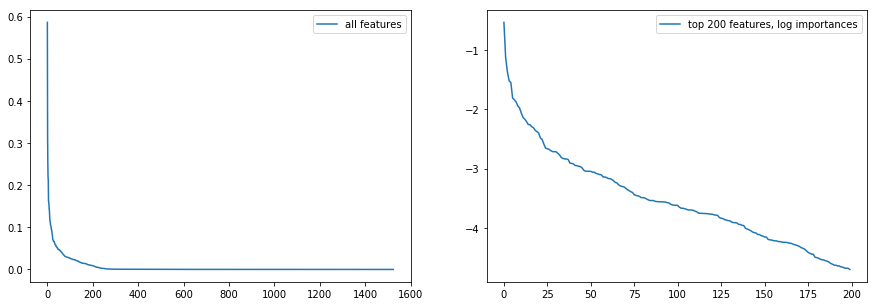

In [537]:
plot_rank(sess.run(exps_l2_0[0].model.weight_layer.w))

кстати стало четче, в смысле в 0 вес фичей уходит увереннее, попробуем еще увеличть лосс

In [576]:
exps_l2_0_l1i, res_exps_l2_0_l1i = run_array('lambda_2_0_l1i', lambda_1=0.01,
                 lambda_2=0,
                 alpha_1=0.00002,
                 alpha_2=0.5)

early stop
exp_results : 0.8746323999488557
early stop
exp_results : 0.8967523334611942
early stop
exp_results : 0.883902314282061


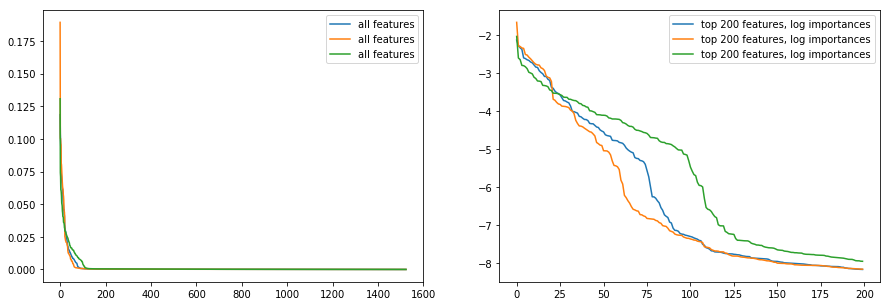

In [585]:
plot_rank(sess.run(exps_l2_0_l1i[0].model.weight_layer.w),
          sess.run(exps_l2_0_l1i[1].model.weight_layer.w),
          sess.run(exps_l2_0_l1i[2].model.weight_layer.w),
         )

Это для трех запусков. Фичи по оси Х могут быть разные! Они тут сортированы по важности.

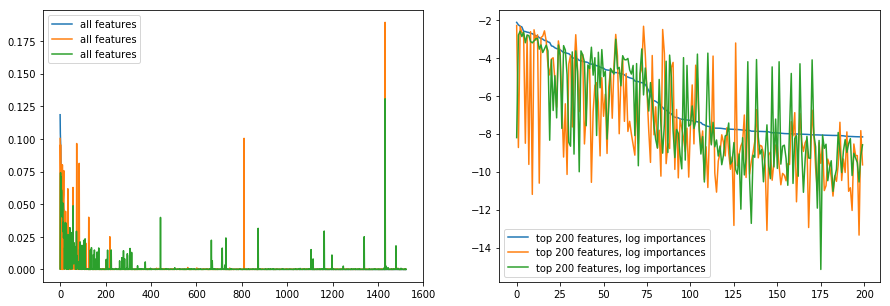

In [592]:
plot_ordered_as_first(sess.run(exps_l2_0_l1i[0].model.weight_layer.w),
          sess.run(exps_l2_0_l1i[1].model.weight_layer.w),
          sess.run(exps_l2_0_l1i[2].model.weight_layer.w),
         )

А вот так будет есть все фичи по оси Х совпадают для трех запусков и отсортированы по важности в первом запуске

#### Вытащим фичи из последнего эксперимента и пока на этом остановимся с DFS

In [593]:
def select_features_stable(exps):
    DFS_selected_features = {}
    
    for exp in exps:
        exp_best_features = np.argsort(sess.run(exp.model.weight_layer.w))[::-1][:300]
        for i, feature in enumerate(exp_best_features):
            if feature in DFS_selected_features.keys():
                DFS_selected_features[feature] += 1 / (i + 1)
            else:
                DFS_selected_features[feature] = 1 / (i + 1)
    DFS_features_array = np.zeros((2, len(DFS_selected_features)))
    for i, (k, v) in enumerate(DFS_selected_features.items()):
        DFS_features_array[0, i] = k
        DFS_features_array[1, i] = v
        
    return DFS_features_array

In [594]:
DFS_features_array_increased_r = select_features_stable(exps_l2_0_l1i)

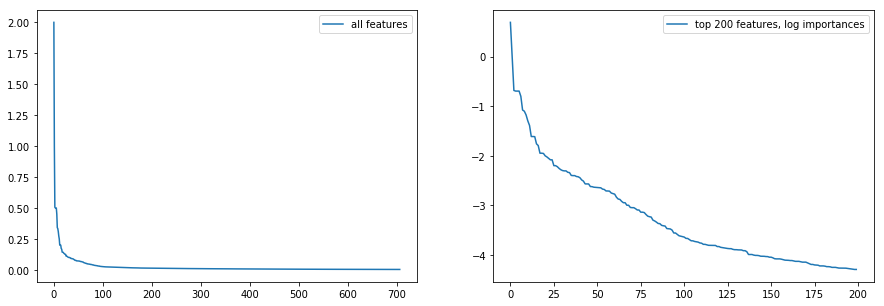

In [595]:
plot_rank(DFS_features_array_increased_r[1])

Попробуем модели от 10 до 200 фичей с каким-нибудь адекватным шагом. Лосс weighted layer отключаем

In [506]:
DFS_scores = np.zeros((2, len(range(10, 200, 15))))

for features in range(10, 200, 15):
    mask = np.zeros(X_tr.shape[1]).astype(bool)
    mask[DFS_features_array[0][np.argsort(DFS_features_array[1])[::-1]].astype(int)[:features]] = True
    
    exp = experiment("DFS_" + str(features), np.ones(X.shape[1]).astype(bool), sess, la)
    exp.run_experiment(X_tr, y_tr, X_te, y_te, 200, plot = False)

    grid_search_results[0, ind] = lambda_1
    grid_search_results[1, ind] = alpha_1
    grid_search_results[2, ind] = max(exp.val_auc_scores)
    print("exp_results :", lambda_1, alpha_1, max(exp.val_auc_scores))

    exps.append(exp)

    ind += 1
    

In [418]:
gr = tf.get_default_graph()

writer = tf.summary.FileWriter("../tf_logs", gr)